# Statistical foundations of machine learning - Richter's Predictor : Modeling Earthquake Damage
### Task I - Data preprocessing, feature engineering, feature selection using PCA and Lasso
### Task II - Training classifiers with Decision Tree, Random Forests and K neighborhood, assessment with kfold crossvalidation
### Task III - Gradient Boosting Tree and assessment
### Task IV - Build predictions for final dataset
### Task V - Feature relevancy computation with entropy

## Dependencies

This notebook was written using R version 4.1.2, with the packages listed below. 

In [1]:
rm(list = ls()) # Wipe memory

# Plotting packages
library(ggplot2) # GGplot2
library(ggfortify) # GGplot2 object interpreter
options(repr.plot.width = 15, repr.plot.height =15) # Sets the size of the ggplots

# Data processing packages
library(dummy) # dummy generation

# Model packages
library(rpart) # Decision Trees
library(rpart.plot) # Decision Trees plotting
library(randomForest) # Random Forest
library(gbm) # Gradient Boosting Model

dummy 0.1.3

dummyNews()

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loaded gbm 2.1.8.1



In [2]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]

    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))

  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]

    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

In [3]:
qualityAssessment = function(y_pred, y_true){
    print("Confusion Matrix")
    print(ConfusionMatrix(y_pred, y_true))
}

## Task I - Data preprocessing, feature engineering, feature selection using PCA and lasso

### Data discussion, preprocessing and feature engineering
In this part we deal with the raw csv files containing the data we will use later on. We do several things here : convert the string type read by R in the csv files to factors, in order to consider them at categorical variables. We check if there are any not available (NA) values in the dataset. We generate dummy variables in order to convert every categorical variables of $k$ levels to $k$ new variables. We assess the proportion of each `damage_grade` level in the dataset.

In [4]:
# Read the train_values.csv file, containing the training data for
# the project. We specify stringAsFactors=True, because we want to
# automatically the categorical variables (which are seen as strings)
# in the original file, to factors. 
data = read.csv("train_values.csv", stringsAsFactors=T)

# Read the train_labels.csv file which we will use as our target
# labels in the training process, as well as the test_values.csv file
# from which we will build the predictions we will submit
trainLabels = read.csv("train_labels.csv")
testValues = read.csv("test_values.csv")

The code below shows that there aren't any not available (NA) values in the dataset.

In [13]:
# is.na(data) returns a matrix with TRUE/FALSE values
# for each component of the data frame data. We then call
# colSums in order to get the amount of NA element per feature.
# Finally, we sum the colsums obtained to get the number of NA
# element in the whole dataset
sum(colSums((is.na(data))))

[1] 0

The code below details the number of categorical features present in the data set with their respective levels. Since we are going to generate dummy variables, we can see that from that code that we will add roughly 38 features (total amount of levels) and remove 8 features (total amount of categorical features), so we can expect a net addition of 30 features to this dataset.

In [5]:
# categories is a function of the package dummy
# that displays each categorical feature and its 
# factor levels.
print(categories(data))

$land_surface_condition
[1] "n" "o" "t"

$foundation_type
[1] "h" "i" "r" "u" "w"

$roof_type
[1] "n" "q" "x"

$ground_floor_type
[1] "f" "m" "v" "x" "z"

$other_floor_type
[1] "j" "q" "s" "x"

$position
[1] "j" "o" "s" "t"

$plan_configuration
 [1] "a" "c" "d" "f" "m" "n" "o" "q" "s" "u"

$legal_ownership_status
[1] "a" "r" "v" "w"



The code below generates `dataDums`, a data frame which contains all the levels of each individual categorical feature, as features. The components are binary, 0 or 1.
Then we define `varsToRemove`, which is a vector contaning the column ids of all 8 categorical features present in the dataset.
Finally, we define `dataPP`, the dataframe composed of the initial data frame `data` without the 8 categorical features we fetched in the previous step, joint with the `dataDums` data frame and the training label `damage_grade` from `trainLabels`. 

In [6]:
# Generate the dataDums data frame with the dummy 
# function from dummy package. Here the option 
# int=TRUE is used to create integer types dummies, 
# instead of the default factor ones
dataDums = dummy(data, int=TRUE)

# Create the vector containing the column ids
# of all categorical fatures in data. The function
# sapply is used to fetch all column names 
# corresponding to the class factor in data[1,]. Here
# we consider just the first line because the type of 
# a variable is the same for all entries in a dataset.
# Finally, we apply the which function on that vector
# in order to get the numerical ids of each column
varsToRemove = which(sapply(data[1,],class)=="factor")

# Finally we create the dataPP (preprocessed) data frame
# which is a merging between the data dataframe without
# the 8 fetched categorical features ids, the dataframe 
# containing the dummy variables dataDums and the training
# labels damage_grade, that will be our target variable
damage_grade = trainLabels$damage_grade
dataPP = cbind(data[,-varsToRemove], dataDums, damage_grade)

# We set the rownames of the dataPP data frame to be the 
# specified building_id, then we drop the building_id
# column from the data frame
rownames(dataPP) = dataPP$building_id
dataPP = dataPP[,-1]

head(dataDums)
print(varsToRemove)
head(dataPP)

,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,⋯,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,1,0


land_surface_condition        foundation_type              roof_type 
                     9                     10                     11 
     ground_floor_type       other_floor_type               position 
                    12                     13                     14 
    plan_configuration legal_ownership_status 
                    15                     27 


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,⋯,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
802906,6,487,12198,2,30,6,5,1,1,0,⋯,0,0,0,0,0,0,0,1,0,3
28830,8,900,2812,2,10,8,7,0,1,0,⋯,0,0,0,0,0,0,0,1,0,2
94947,21,363,8973,2,10,5,5,0,1,0,⋯,0,0,0,0,0,0,0,1,0,3
590882,22,418,10694,2,10,6,5,0,1,0,⋯,0,0,0,0,0,0,0,1,0,2
201944,11,131,1488,3,30,8,9,1,0,0,⋯,0,0,0,0,0,0,0,1,0,3
333020,8,558,6089,2,10,9,5,0,1,0,⋯,0,0,0,0,0,0,0,1,0,2


Now regarding the data distribution, we can for instance assess the number of observations for each of the three `damage_grade` levels. The code below computes the percentage of each `damage_grade` level in the dataset, and plots the counts in a barplot. As we can see, this `damage_grade` feature is not distributed evenly between its different levels. In fact, levels 2 and 3 are occuring far more often that the level 1 (about 90% of the set fits either in level 2 or 3).

Percentages of the dataset corresponding to each damage_grade level 
 damage_grade=1:  9.64079186188848 
 damage_grade=2:  56.8911861428007 
 damage_grade=3:  33.4680219953108

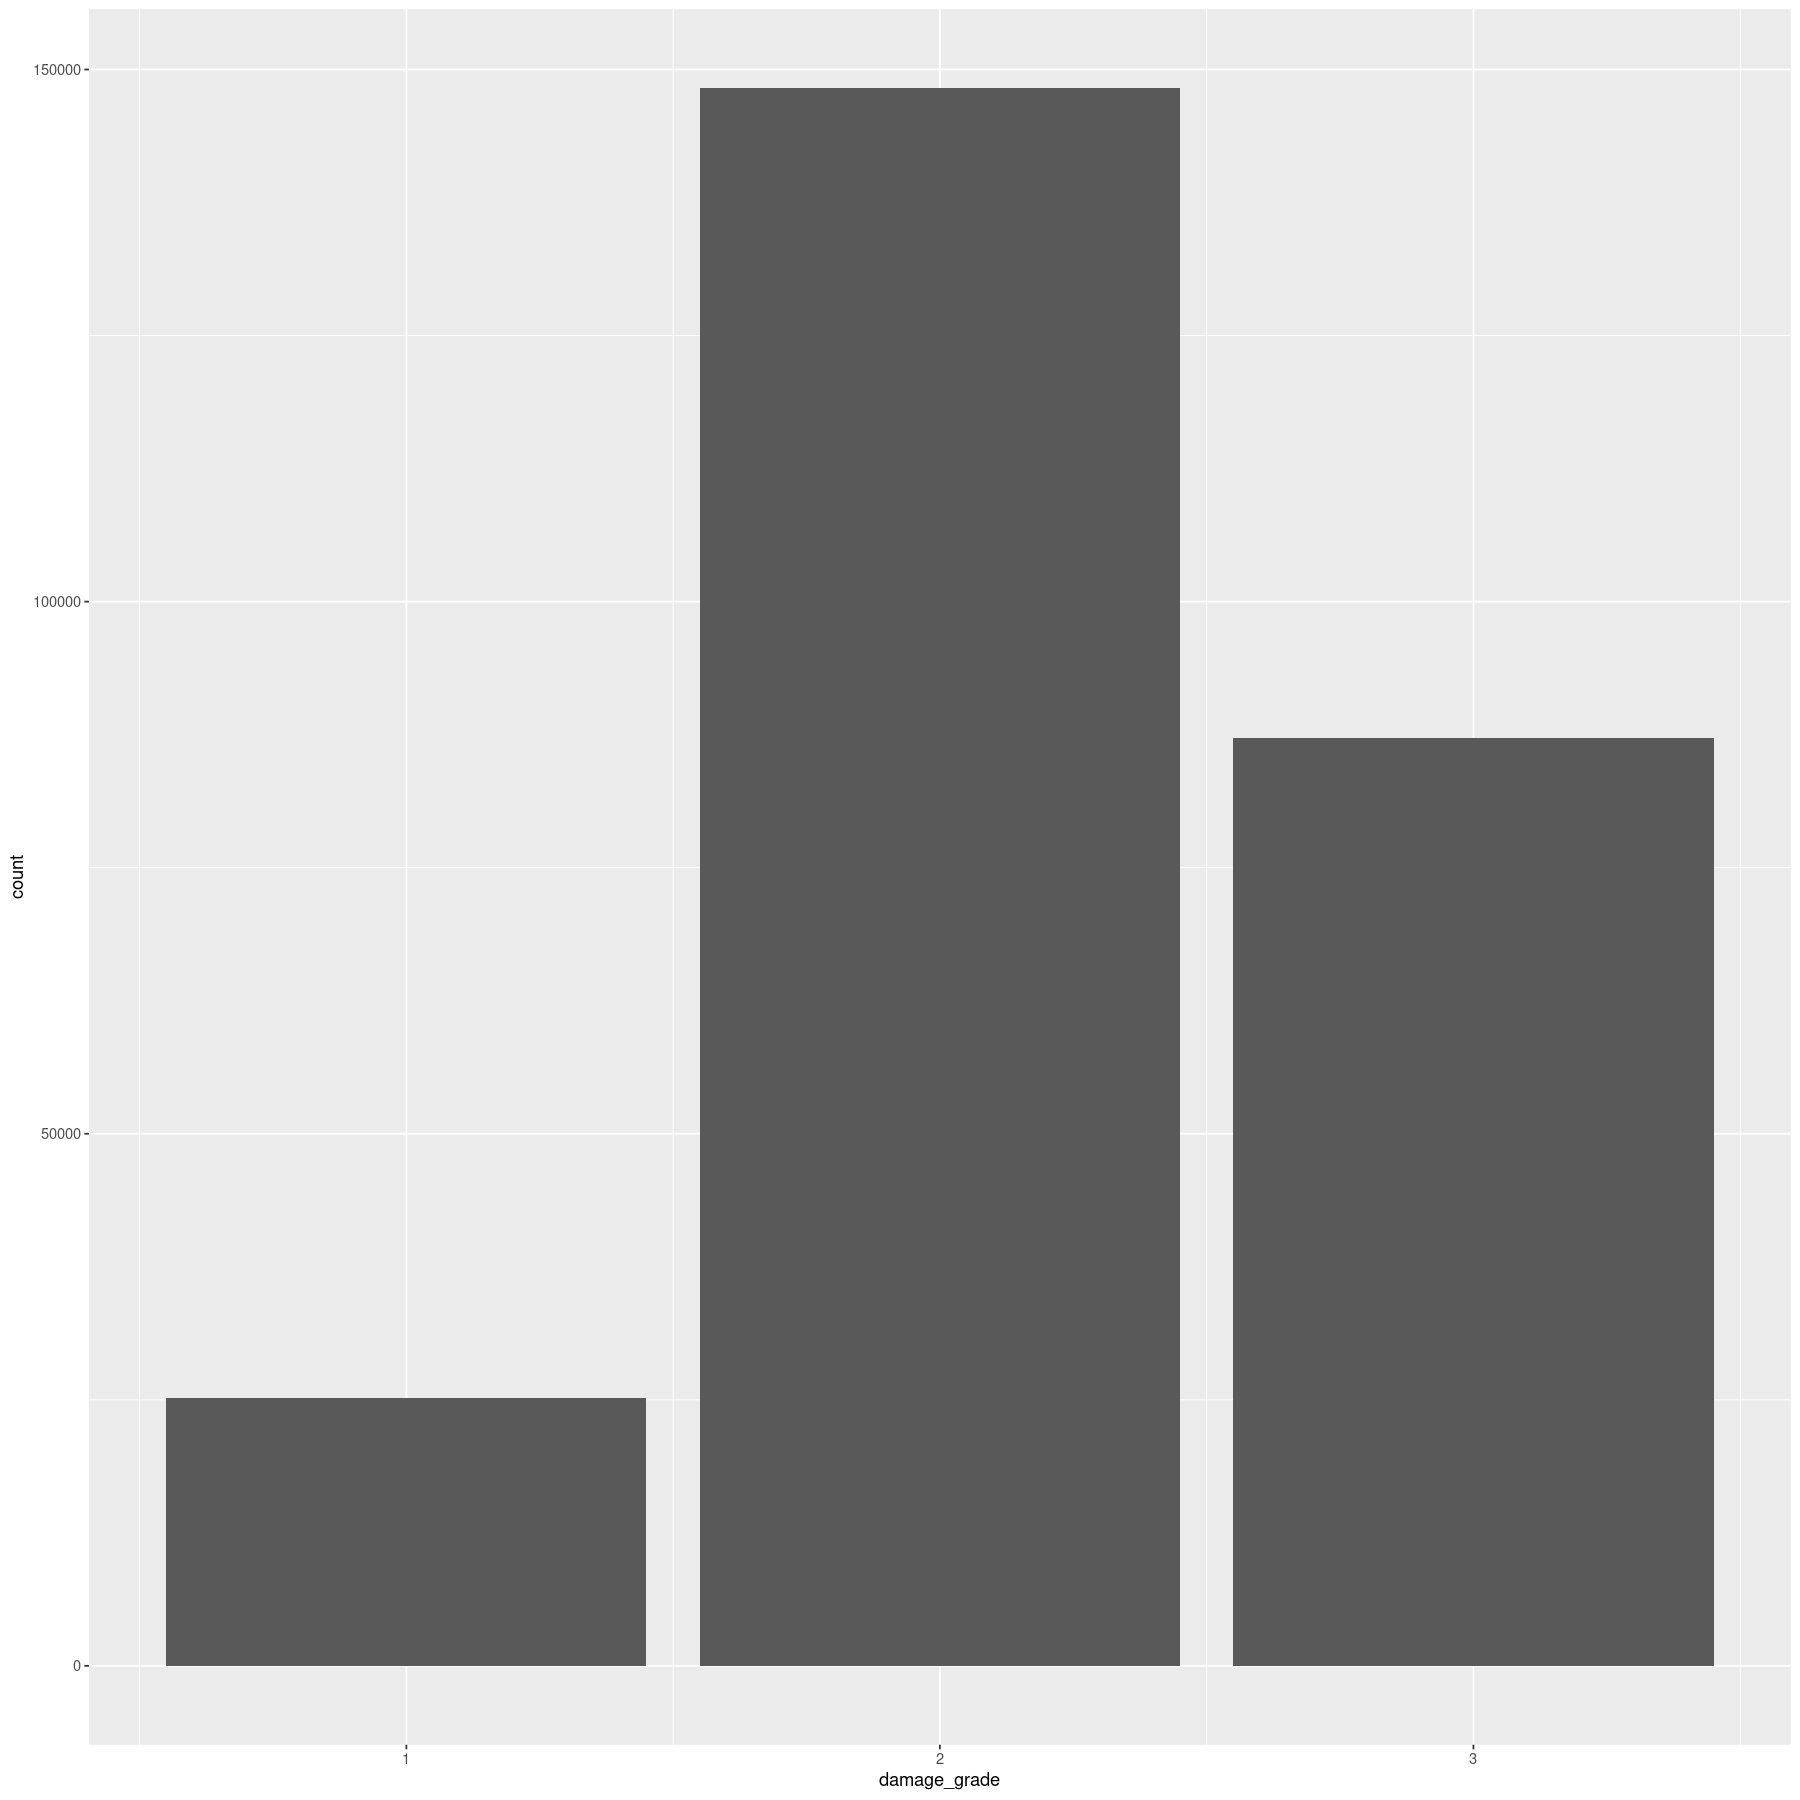

In [7]:
ggplot(dataPP, aes(x= damage_grade)) + geom_bar()


numberOfEntries = nrow(dataPP)
cat(paste0("Percentages of the dataset corresponding to each damage_grade level \n"))
cat(paste0(" damage_grade=1:  ", nrow(subset(dataPP, damage_grade==1))/ numberOfEntries *100),"\n", 
    "damage_grade=2: ", paste0(nrow(subset(dataPP, damage_grade==2))/ numberOfEntries *100), "\n", 
    "damage_grade=3: ", paste0(nrow(subset(dataPP, damage_grade==3))/ numberOfEntries *100))

### Feature selection using PCA and lasso
In this part we discuss the feature selection process using two different approaches, the Principal Component Analysis and the Lasso. Let us first start with the PCA approach.

In the code below, we generate a pca object, and plot the two first principal axes of the PCA. 

In [43]:
# Generate a pca object using the prcomp function
# we discard the first column (building_id) as it
# is an identifier more than an actual measure. 
# We specify scale=TRUE so that all variables have
# a unit variance. 
pca = prcomp(dataPP, scale=TRUE)

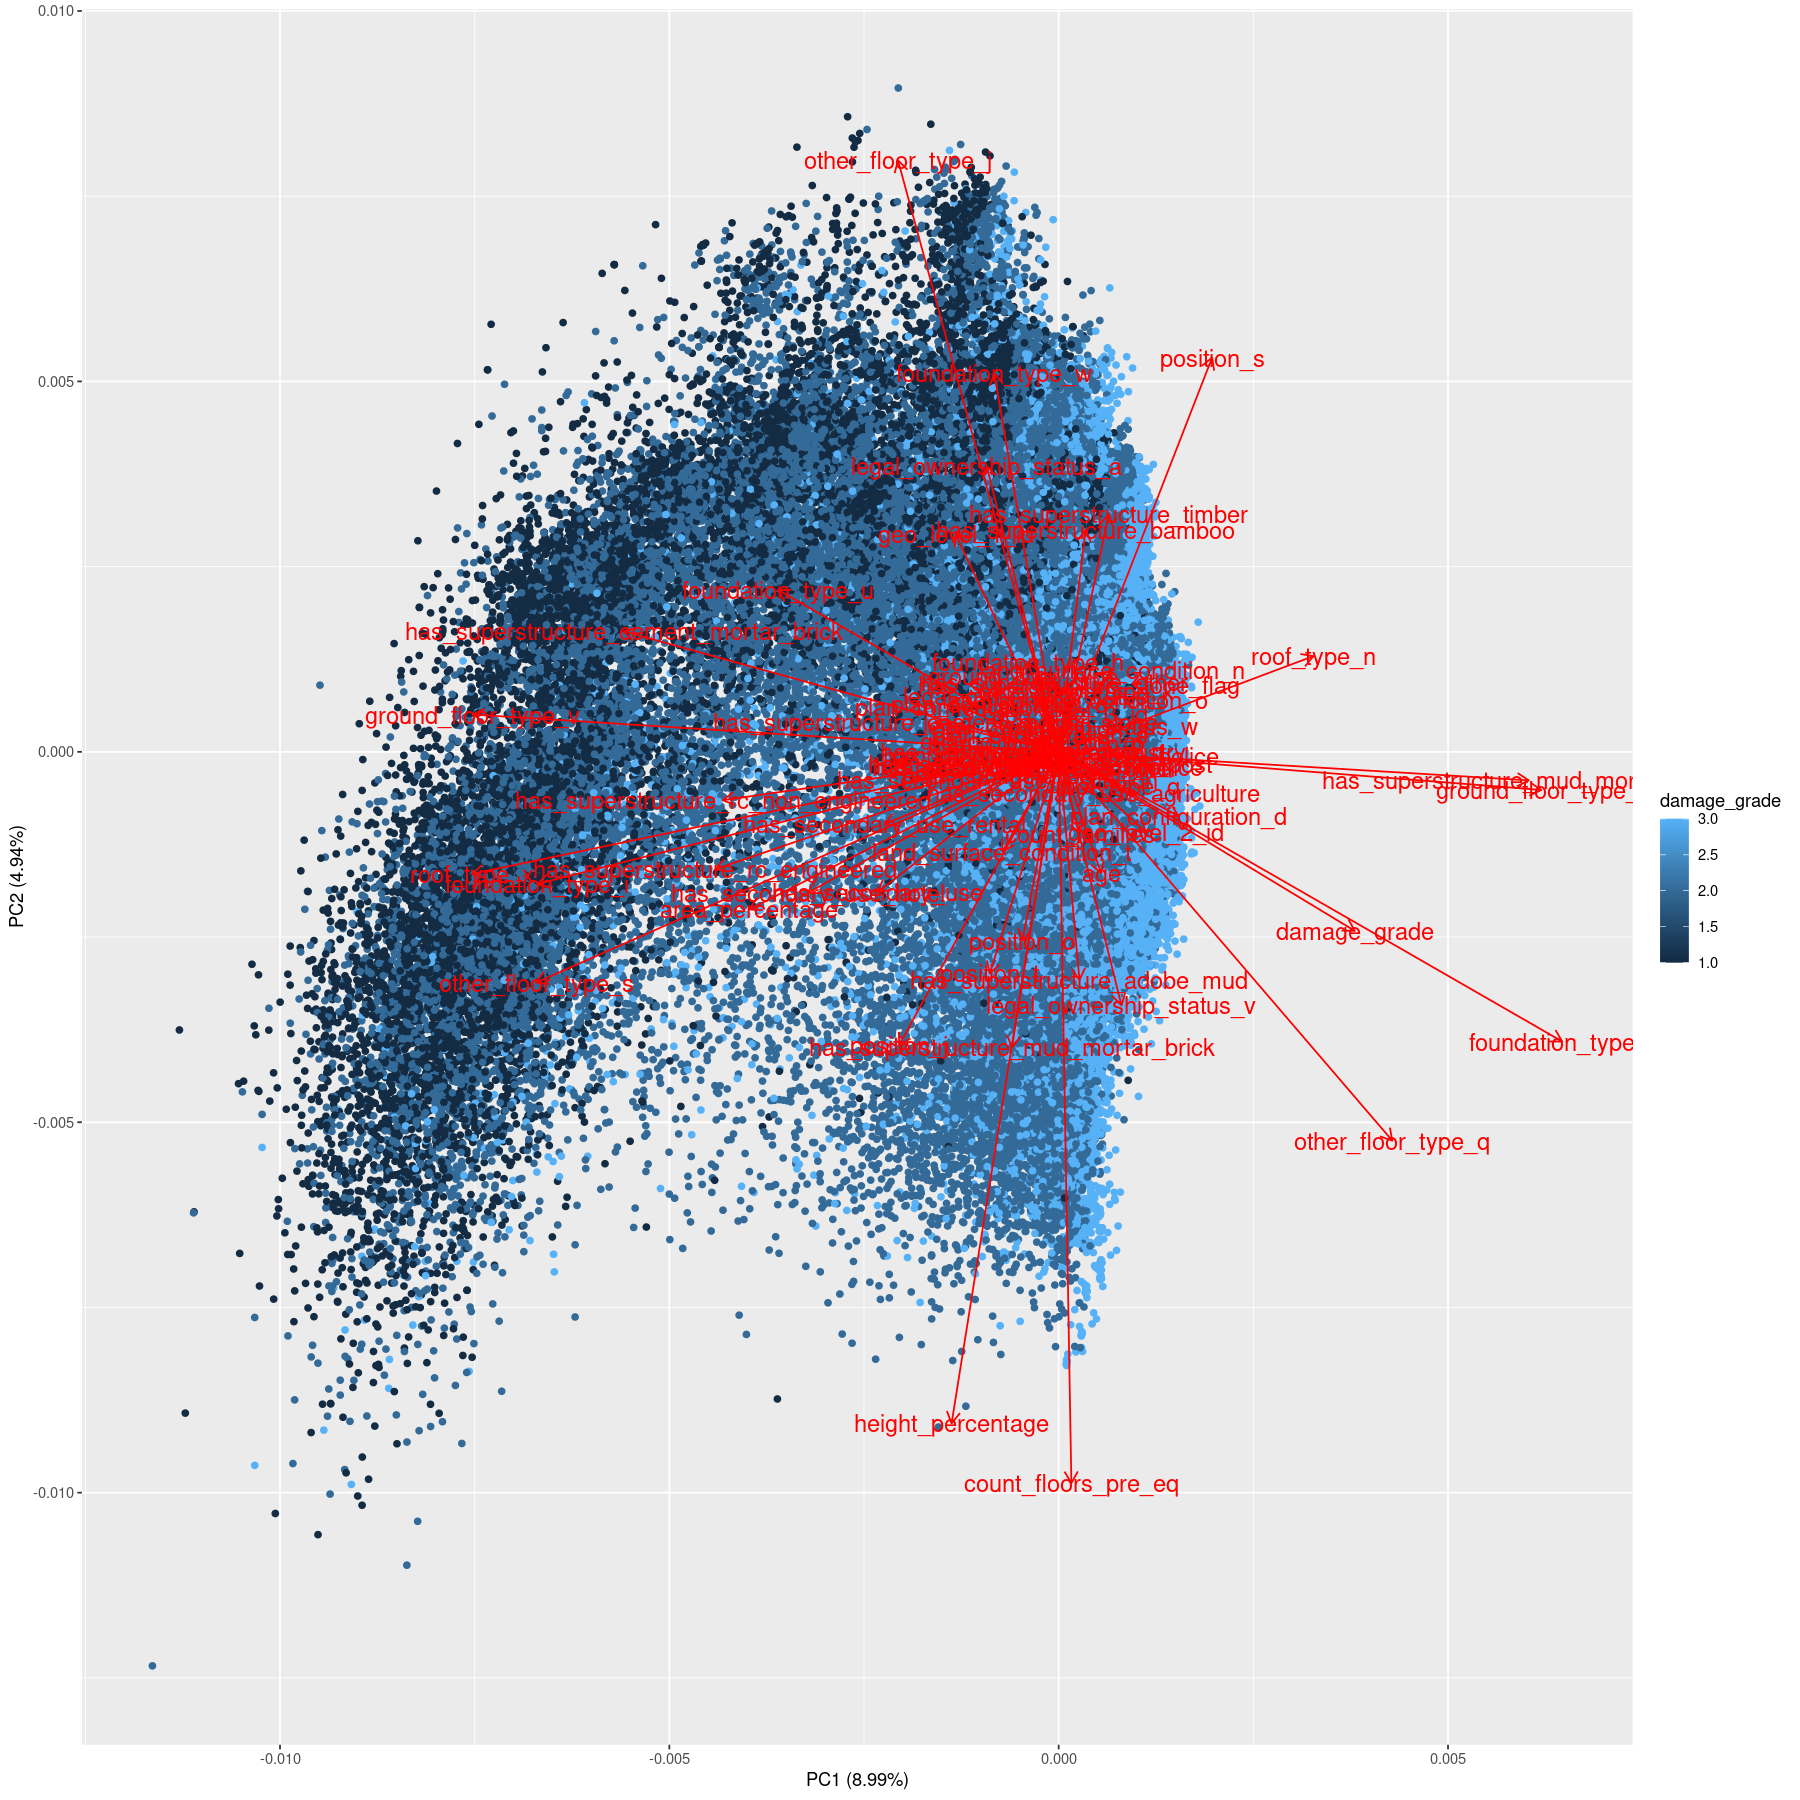

In [46]:
# Calls autoplot to plot the pca object
# we specify on x the first axis and on y the second axis
# we specify the data, as well as the colour of the dots
# that will be based on the damage_grade value. We specify
# loadings = True to display each feature's contribution to 
# each axis, display the label of each loading, specify a 
# label size 
autoplot(pca, x = 1, y = 2, 
        data = dataPP, colour = 'damage_grade', 
        loadings = TRUE, loadings.label = TRUE, loadings.label.size = 5)

If we select the first 50 axes, we will have explained 94% of the variance in this dataset. Since the variance explained by each axis is so small (9% in the first case, 5% in the second case etc...), it becomes hard to do any feature selection based on the PCA results. Indeed, if we for instance think that we could pick for each axis the features that have the biggest loading, we might end up with almost as many features as we started with (because there is no guarantee that a feature that contributes a lot to a given axis contributes much to other axes)

This part would be much easier if we had few axes that explained most of the variance in the dataset, rather than needing 50 to explain 94%. 
The code below shows the calculation for the variance explained mentionned here, and plots the variance explained by each axis.

In short, we assessed how the PCA applied to our dataset. Because of the amount of axes it computed and the weak variance explained by each of them, picking features based on the PCA in this case did not really work out. 

Variance explained by the first 50 axes: 94.3014052138276

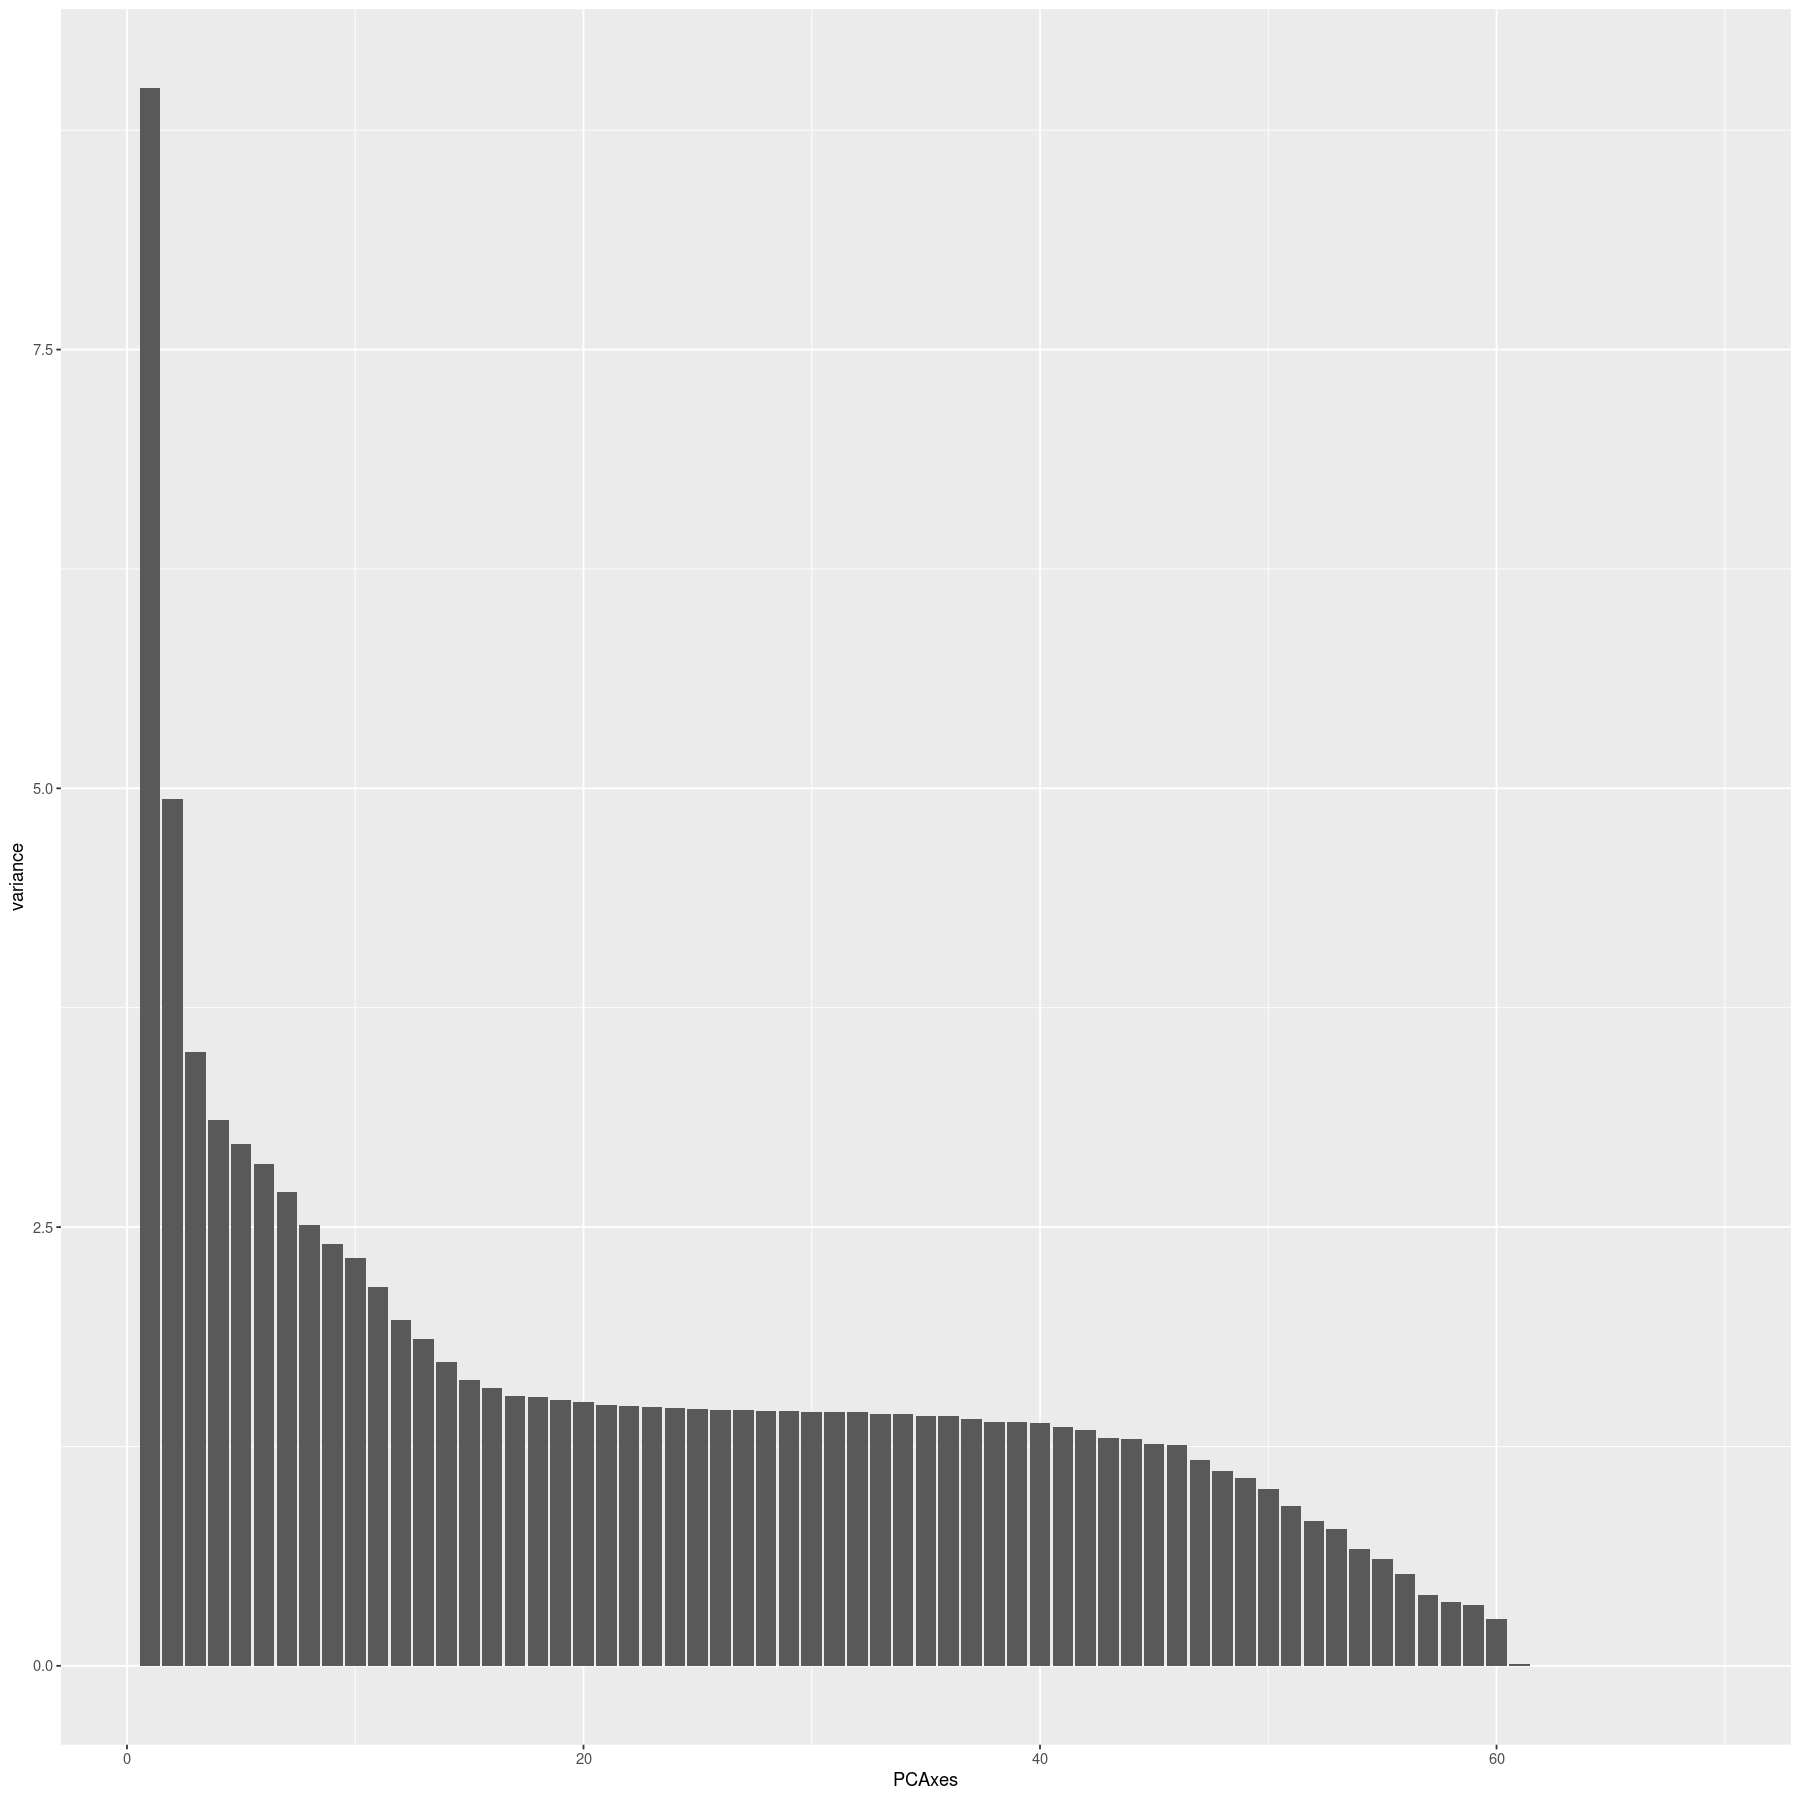

In [47]:
# Compute a vector variance that contains
# the dataset variance explained by each 
# axis', in percentage
variance = (pca$sdev^2 / sum(pca$sdev^2))*100

# Print the sum (total variance explained)
# of the variance vector for the first 50 axes
cat(paste0("Variance explained by the first 50 axes: ", sum(variance[1:50])))

# For the plot, first define a dataframe d that
# contains the axis number and the variance it 
# explains. Finally call ggplot and specify columns
# to obtain a barplot
d = data.frame(PCAxes=c(1:69), variance) 
ggplot(d, aes(PCAxes, variance)) + geom_col() 

We tackle now a Lasso based feature selection

## Task 2 : Decision Tree, Random Forests and K-Neared neighbors models

Now that we are done with the PCA analysis, we can convert our `damage_grade` response to a factor (we needed it as an integer for the PCA)

In [8]:
dataPP$damage_grade = as.factor(dataPP$damage_grade)

### Decision Tree

#### Decision on `cp` parameter
In order to get a good classifier, we must decide on a `cp` value (the complexity parameter). Decreasing the `cp` value results in having more nodes in our decision tree, and can lead to overfit - which we want to avoid, so in order to decide on the right value for it, we must take into consideration two things : we want a tree that has a low X-validation error, and we want a tree that is not too complex to avoid overfitting. 

In order to find the right `cp` value, we train a model using the `cp=0` value, in order to assess in what range of tree size most of the X-validation error decrease happens. In our case, it seems that the most optimal value is around `cp=0.00002`, which results in a decision tree with about 1900 nodes.

In [107]:
# Train a decision tree classifier using rpart
# on the whole dataset, specifying the response
# variable to be damage_grade. This time we 
# specify a cp=0.005, as explained above
decisionTreeModel = rpart(damage_grade ~., data=dataPP, cp=0, method="class")

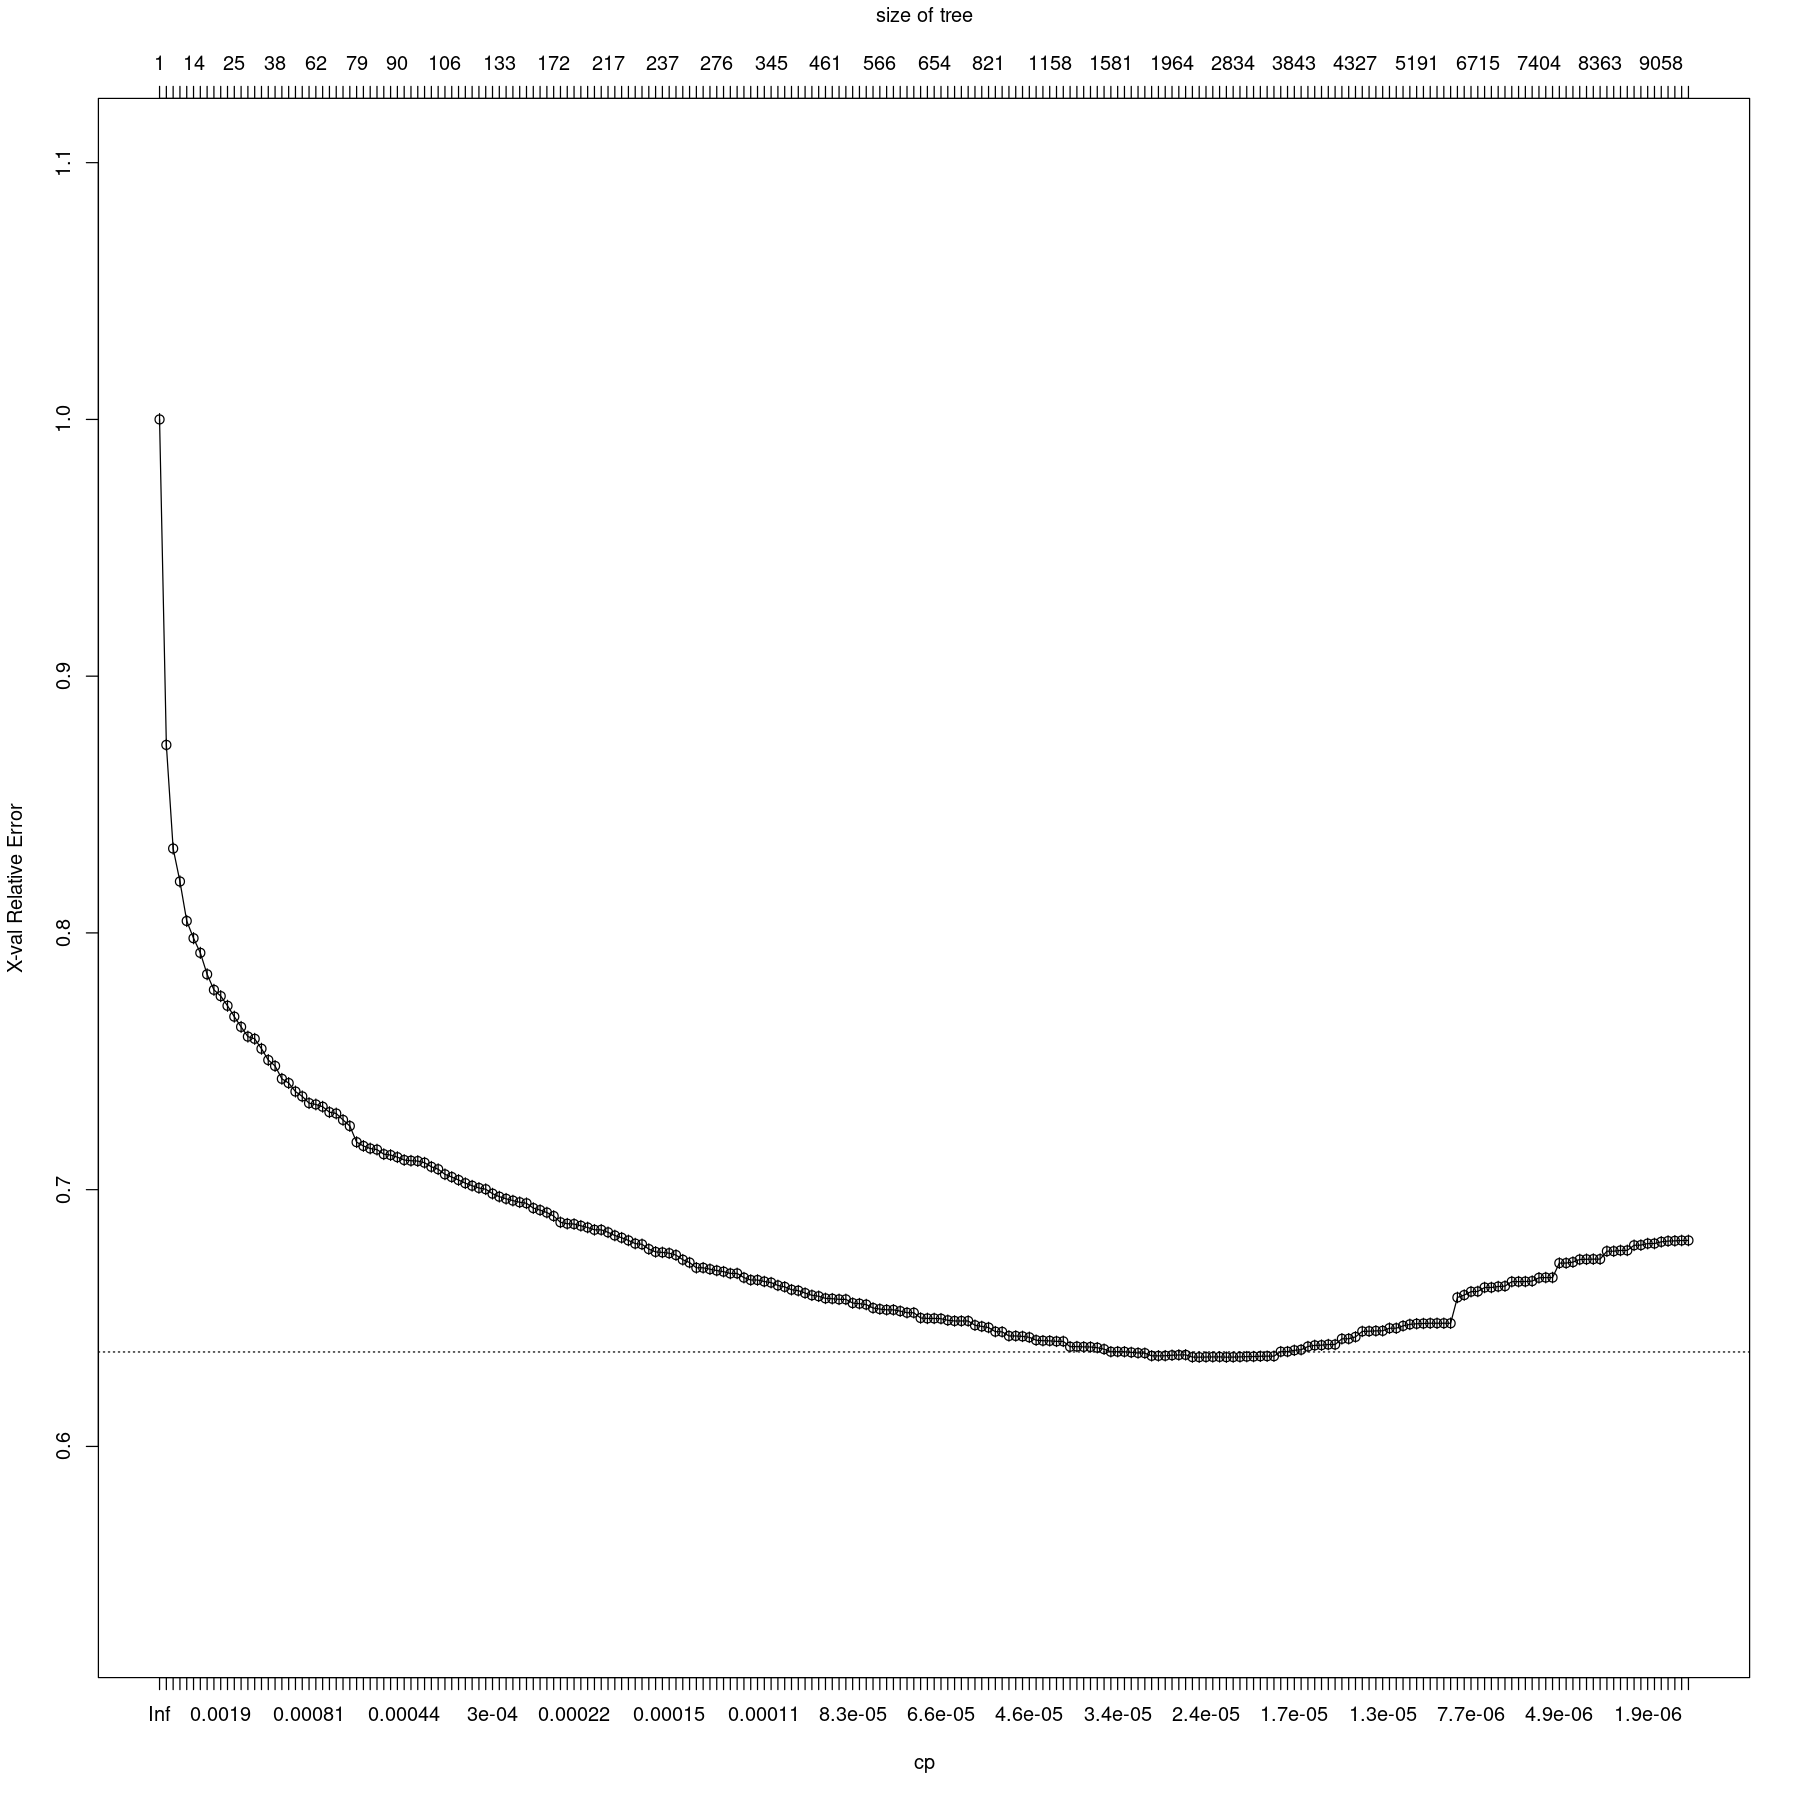

In [108]:
plotcp(decisionTreeModel)

#### Quality assessment of the model through k-fold cross validation
In this part we want to assess how good and reliable a decision tree model would be at predicting the classes `damage_grade` in our dataset. In order to do that, we use a k-fold cross validation. Here we ran the cross validation with 10 folds, which means we train 10 classifiers on 10 different combinations of training set/validation sets. From this algorithm we can compute the mean value of the F1 statistics obtained for each of the classifier, as well as the standard deviation. This gives us an idea of how "robust" our model is depending on different training/validation set combinations. In the run below, we obtained a mean $F1 = 0.726167764355289$ with a standard deviation of $0.00244045399174821$.

In [113]:
# Define the function kFDecisionTree which is used
# to perform kfold cross validations of a decision
# tree model over the data set.
kFDecisionTree = function(k, data){

    # First we initialize the vector that will contain
    # the F1 measures for each individual classifier
    f1 = c()
    
    set.seed(2023)
    shuffled = sample(1:nrow(data))
    max = ceiling(nrow(data)/k)
    splits = split(shuffled, ceiling(seq_along(shuffled)/max))

    # 3. For each unique group:
    for (i in 1:k){
        #3.1 Take the group as a hold out or test data set
        test_data = data[splits[[i]],]
        
        #3.2 Take the remaining groups as a training data set
        train_data = data[-splits[[i]],]
        #3.3 Fit a model on the training set and evaluate it on the test set
        model = rpart(damage_grade ~ ., method="class",data=train_data, cp=0.00002)
        
        predictions = predict(model,test_data[,-69])
        predictions = colnames(predictions)[apply(predictions,1,which.max)] 

        f = F1_Score_micro(test_data$damage_grade, predictions)
        cat(paste0(f, "\n"))
        f1 = c(f1,f)
        
    }
    
    # Print out the mean F1 metric as well as the standard deviation
    cat(paste0("Mean F1 metric: ", mean(f1), "\n"))
    cat(paste0("Standard deviation F1 metric: ",sd(f1))) 
    
}

In [114]:
# result for cp=0.00002
kFDecisionTree(10, dataPP)

0.723610.72410880.7233030.72671810.72633440.72537510.7289820.72583550.72618090.7312298Mean F1 metric: 0.726167764355289
Standard deviation F1 metric: 0.00244045399174821

#### Discussion about feature relevancy in our model
Now that we assessed the reliability of our model with respect to the possible combinations of training/validation sets, we can train a model with the whole training set. This allows us to clearly see, by taking the whole dataset for training, which are the most critical features for this model.

The code below allows us to visualize which features contributes the most to the obtain model tree, it is complementary with the question of Task 5, and hints us at what to expect from the last question's calculations.

In [115]:
decisionTreeModel = rpart(damage_grade ~., data=dataPP, cp=0.00002, method="class")

In [116]:
# Convert the variable importance from the model we built
# to a data frame 
varImpDT = data.frame(decisionTreeModel$variable.importance) 

# Add a feature column corresponding to the features names
varImpDT <- data.frame(feature = row.names(varImpDT), varImpDT) 

# Change the column names of the data frame to "feature" and "importance"
colnames(varImpDT) = c("feature", "importance") 

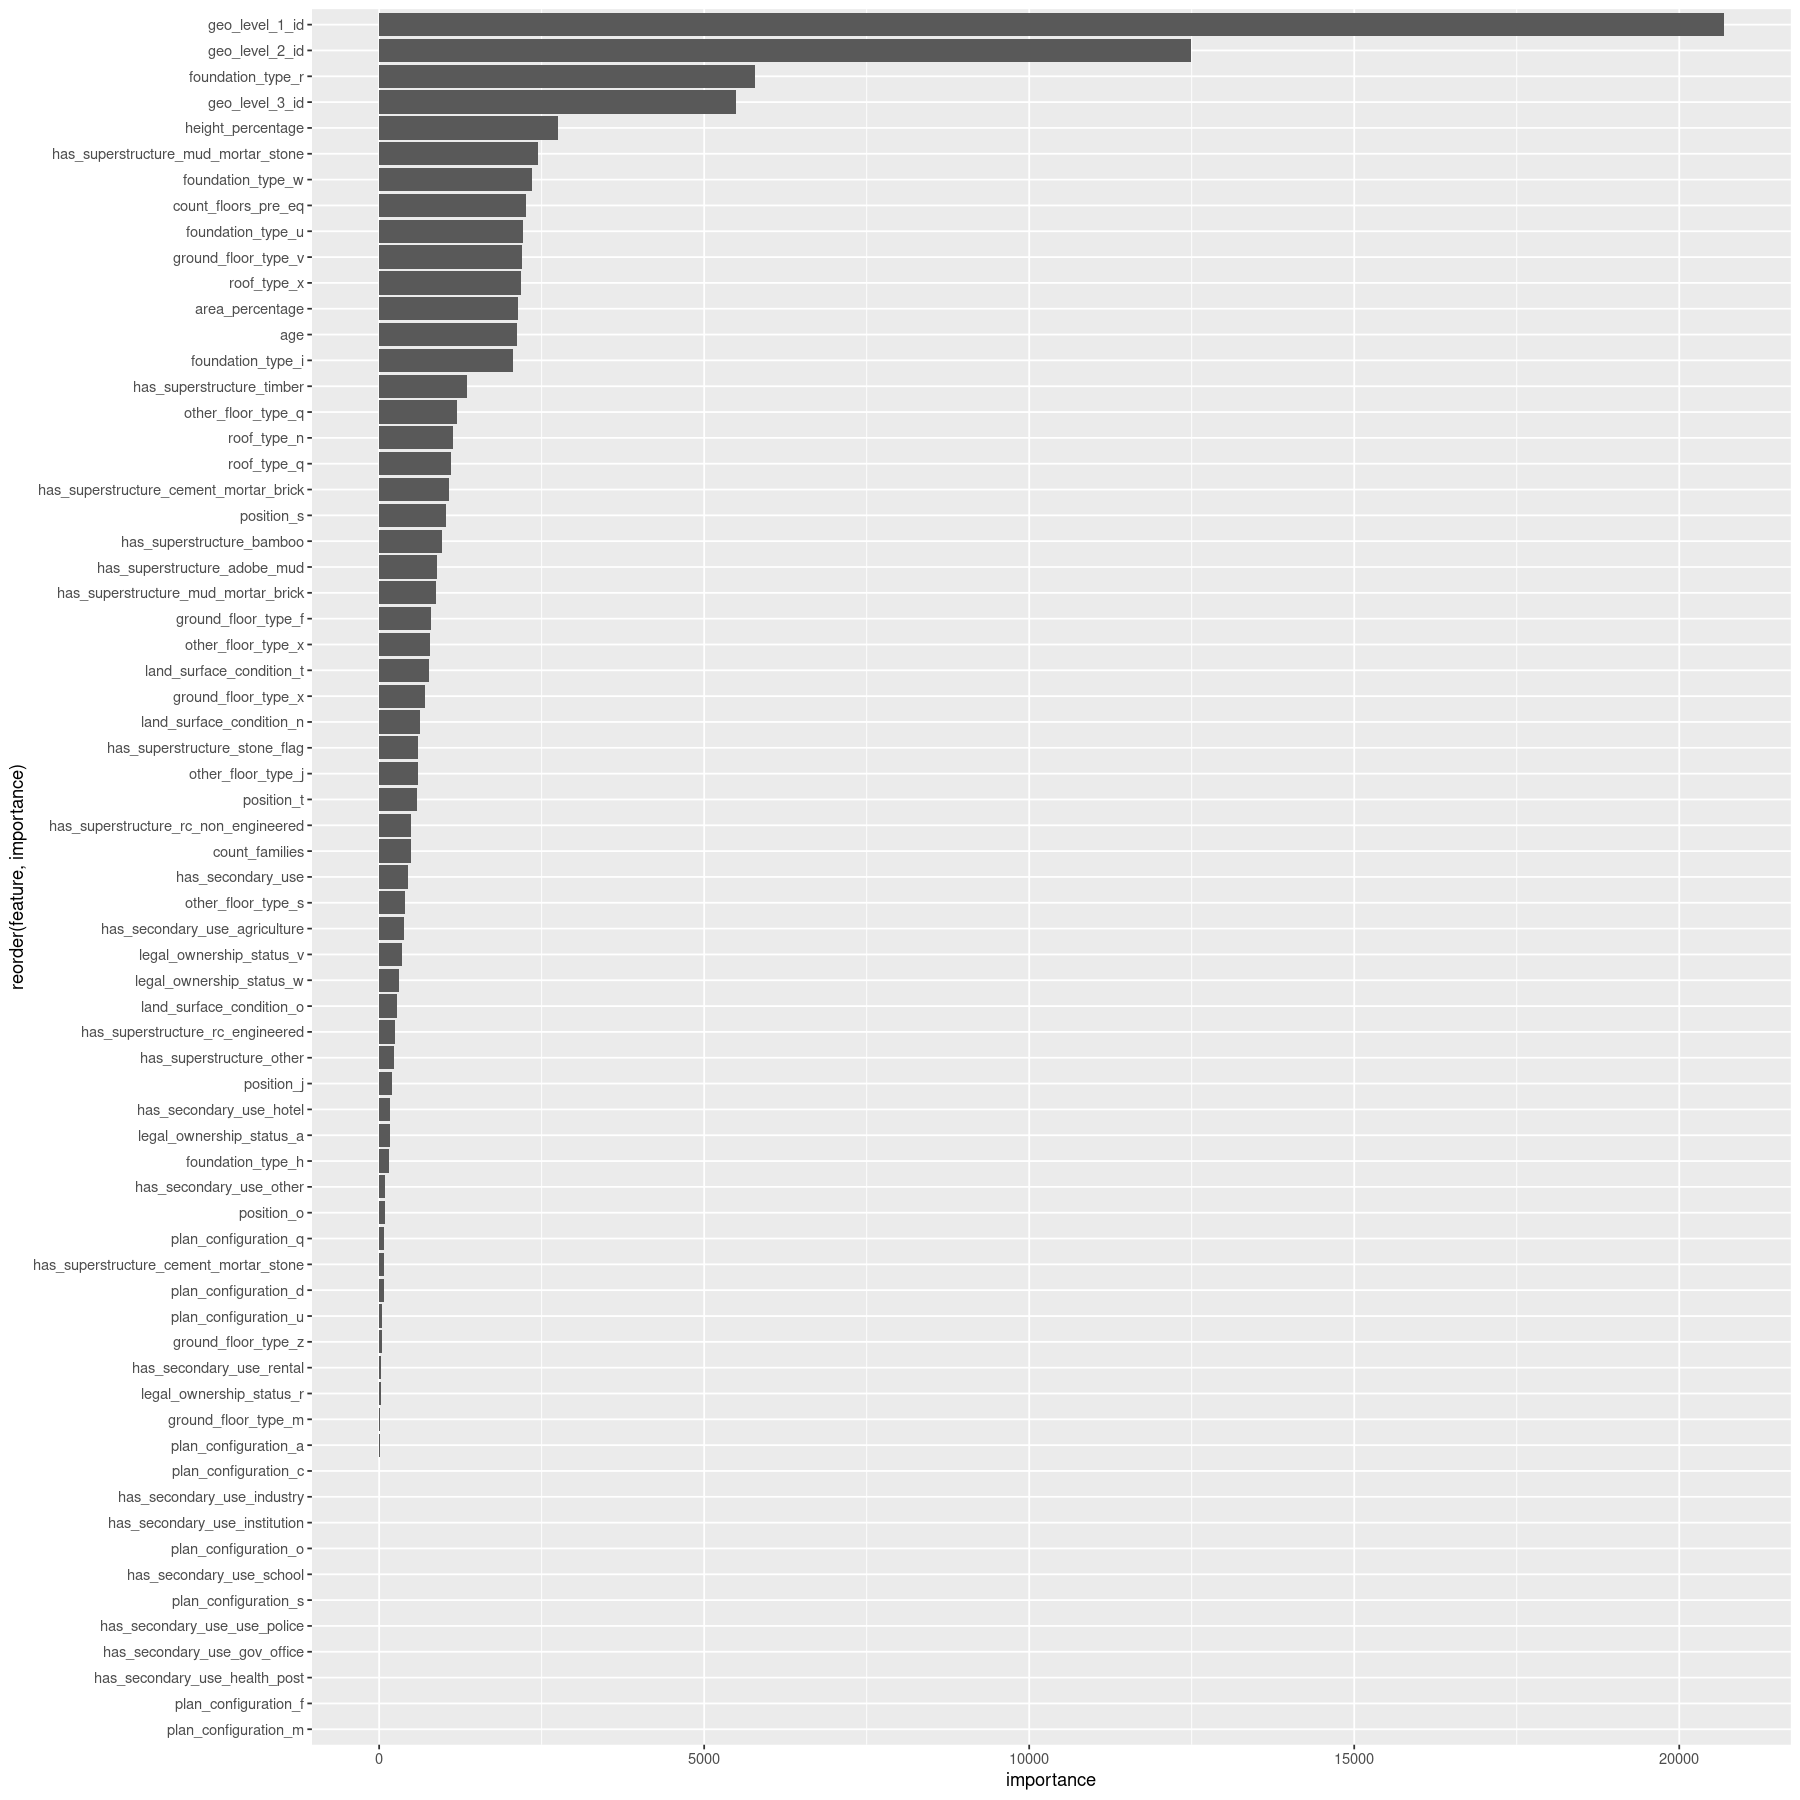

In [117]:
# Call ggplot, specify x to be the importance and y to be a 
# re-ordering of the feature based on their respective importance. 
# We list importance on the x axis to avoid the feature names to overlap
ggplot(varImpDT, aes(x= importance, y=reorder(feature, importance))) + geom_bar(stat='identity')

## Task 3 : Gradient Boosting Tree

## Model robustness assessment using 10-fold crossvalidation
- In this part, we build a function `kFGBT`, in order to assess the robustness of our model (the gradient boosting tree) through different combinations of training/validation set.
- We compute a mean F1 (performance measure through the different combinations of training/validation sets), and it's standard deviation, in order to assess how reliable our model is when working on different subsets of the original training data.
- Mean F1 metric: 0.668577631867685
Standard deviation F1 metric: 0.00184923218418441
- In the run below, we obtained For one run we obtain $F1 = 0.6399477$ with a standard deviation of $0.002906588$

## Final model training, discussion about features relevancy in this model
- Now that we assessed the reliability of our model with respect to the possible combinations of training/validation sets, we can train a model with the whole training set. 
- This allows us to clearly see, over the whole dataset, which are the most critical features for this model. We will use that model later on to build the final prediction (see Task 4).

In [13]:
gradientBoostingTreeModel = gbm(damage_grade ~., data=dataPP[,-1], n.trees=500)

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”


**Features relevancy**
- The code below allows us to visualize which features contributes the most to the obtain model tree. 
- We can see that the feature `geo_level_id` is the one that contributes the most
- High in that list are 4 levels of the feature `foundation_type` : r, i (h, w, u, misses)
- Then `ground_floor` type : v
- `has_superstructure_mud_mortar_stone` 
- `age` 
- `has_superstructure_cement_mortar_brick` 

In [14]:
varImpGBM = summary.gbm(gradientBoostingTreeModel, plotit=FALSE) # Transform the variable.importance column of the model to a data frame
colnames(varImpGBM) = c("feature", "importance") # Change colnames of the df to feature and importance
varImpGBM = subset(varImpGBM, importance!=0) # Because this data frame contains a lot of feature importance = 0, we discard them

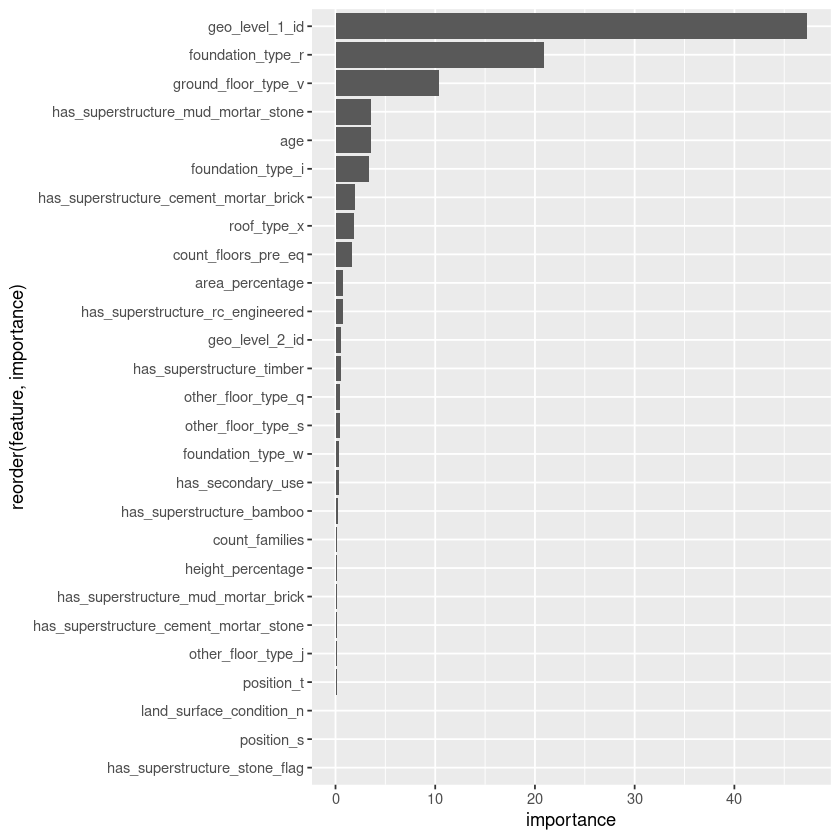

In [171]:
# Call ggplot, speicify x to be the importance and y to be a re-ordering of the feature based on their respective importance. 
# We list importance on the x axis to avoid the feature names to overlap
ggplot(varImpGBM, aes(x= importance, y=reorder(feature, importance))) + geom_bar(stat='identity')

In [8]:
# Define the function kFDecisionTree which is used
# to perform kfold cross validations of a decision
# tree model over the data set.
kfGBM = function(kfold, data){

    # First we initialize the vector that will contain
    # the F1 measures for each individual classifier
    f1 = c()

    # Then we split the set into kfold layers of indices
    # Meaning that each entry in the dataset is assigned to
    # a particular index between 1 and kfold. We specify
    # labels=FALSE in order to get integers values rather
    # than factor values
    folds = cut(seq(1,nrow(data)),breaks=kfold,labels=FALSE) 

    # Loop over the number of folds specified kfold
    for(i in 1:kfold){ 
        
        # Fetch the data whose fold index is i
        indices = which(folds==i,arr.ind=TRUE)

        # Keep the kfold-1 folds from data as being the testData
        testData = data[indices,] 

        # Use the i-th fold from data as being the trainData
        trainData = data[-indices,]

        # Traing a classifier using the trainData and specifying
        # in the formula we want to predict damage_grade
        model = gbm(damage_grade ~., data=data, n.trees=500)

        # Get predictions for the whole testData set, without
        # the damage grade variable
        pred = predict(model, testData[,-70]) 

        # Since the function predict in this case returns a data frame
        # that contains three columns for each level of damage_grade,
        # contaning probabilities that the entry corresponds to a 
        # specific level, we define the predicted level as being
        # the column name (1,2 or 3) that has the biggest value of the line.
        # We do that for all lines
        preds = colnames(pred)[apply(pred,1,which.max)] 

        # Finally, we can add to our f1 metric vector the new F1 metric
        # computed on the vector of prediction preds.
        f1 = c(f1,F1_Score_micro(testData$damage_grade, preds))

    }
    
    # Print out the mean F1 metric as well as the standard deviation
    cat(paste0("Mean F1 metric: ", mean(f1), "\n"))
    cat(paste0("Standard deviation F1 metric: ",sd(f1))) 
    
}

In [9]:
kfGBM(5, dataPP[,-1])

Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




Distribution not specified, assuming multinomial ...


Warning message:
“Setting `distribution = "multinomial"` is ill-advised as it is currently broken. It exists only for backwards compatibility. Use at your own risk.”
Using 500 trees...




Mean F1 metric: 0.668577631867685
Standard deviation F1 metric: 0.00184923218418441

# Task 4 : Predictions building

# Task 5 : Features relevancy ranking
$$Rel(\textbf{x}_i) = H(y|X^{-i}) - H(y|X)$$

- Let's compute the conditional entropy of the target $\textbf{y}$ given $\textbf{X}$, the dataset containing the vectors $z_j$ of size 70
- Using that $H(\textbf{y}|\textbf{X}) = E_{\textbf{X}}[H(\textbf{y}|X)] \textit{(2.15.5.2)}$ and that $H(\textbf{y}|X=z) = \displaystyle{\sum_{y} \mathbb{P}(\textbf{y}=y | X = z) \cdot \log_2(\mathbb{P}(\textbf{y}=y|X=z))}$, we get 
$\begin{equation}
\begin{split}
 H(\textbf{y}|\textbf{X}) &= E_{\textbf{X}}[H(\textbf{y}|X)] \\
& = E_{\textbf{X}}[\displaystyle{\sum_{y \in \text{damage grade}}} \mathbb{P}(\textbf{y}=y|X=z)\cdot \log_2(\mathbb{P}(\textbf{y}=y|X=z)))] 
\end{split}
\end{equation}$ where $z_j$ is the $j$-th observation of the dataset $X$.
- Similarly for the conditional entropy of the target $\textbf{y}$ given $X^{-i}$, we compute it the same way except for this time we remove the $i$-th component of the vectors $z_j$ that are now of size 69.

First, we build a `rpart` model with the whole dataset. Then we predict the `damage_grade` value of each of the entries in that dataset, and finally we compute the entropy value of it.

Second, we loop over all the features and at each iteration, build a model of the whole dataset without that specific feature. Then, build predictions for the whole dataset and compute entropy as before. Finally we can compute $Rel(\textbf{x}_i)$.

In [55]:
entropiesDiscardingI = function(data, i){

    columnToPredict = ncol(dataPP)

    if(i==0){
        modeli = rpart(damage_grade~., data=data, cp=0.00002)
        preds = predict(modeli, dataPP[,-columnToPredict])
    }else{
        modeli = rpart(damage_grade~., data=data[,-i], cp=0.00002)
        preds = predict(modeli, dataPP[,-c(i,columnToPredict)])
    }

    dim(preds) = c(260601,3) # because originally dimensions 250601,3,1
    preds[preds[,1] == 0] = 0.000000000001 # we need to avoid some predictions which would give a probability of 0, for the log
    preds[preds[,2] == 0] = 0.000000000001
    preds[preds[,3] == 0] = 0.000000000001
    
    return(- mean( data.frame(preds[,1] * log2(preds[,1]) + preds[,2] * log2(preds[,2]) + preds[,3] * log2(preds[,3]))[,1] ))
}

In [ ]:
relevancy = function(data){

    entropyFullModel = entropiesDiscardingI(data,0)
    cat(paste0("Entropy of the model including all features (H(y|X)) = ", entropyFullModel, "\n"))

    entropies = c()
    for(i in 1:ncol(data)-1){
        entropyWithoutFeatureI = entropiesDiscardingI(data,i)
        cat(paste0("Entropy of the model excluding feature ",i," (", colnames(data[,i]) ,") = ", entropyWithoutFeatureI, "\n"))
        entropies=c(entropies, entropyWithoutFeatureI)
    }

    relev = entropies - rep(c(entropyFullModel), ncol())
    relevanciesDF = data.frame(cbind(colnames(data[,1:ncol(data)-1]), relev))
    relevanciesDF$relev = as.numeric(relevanciesDF$relev)

    return(relevanciesDF)
}

In [ ]:
relevancies = relevancy(data)

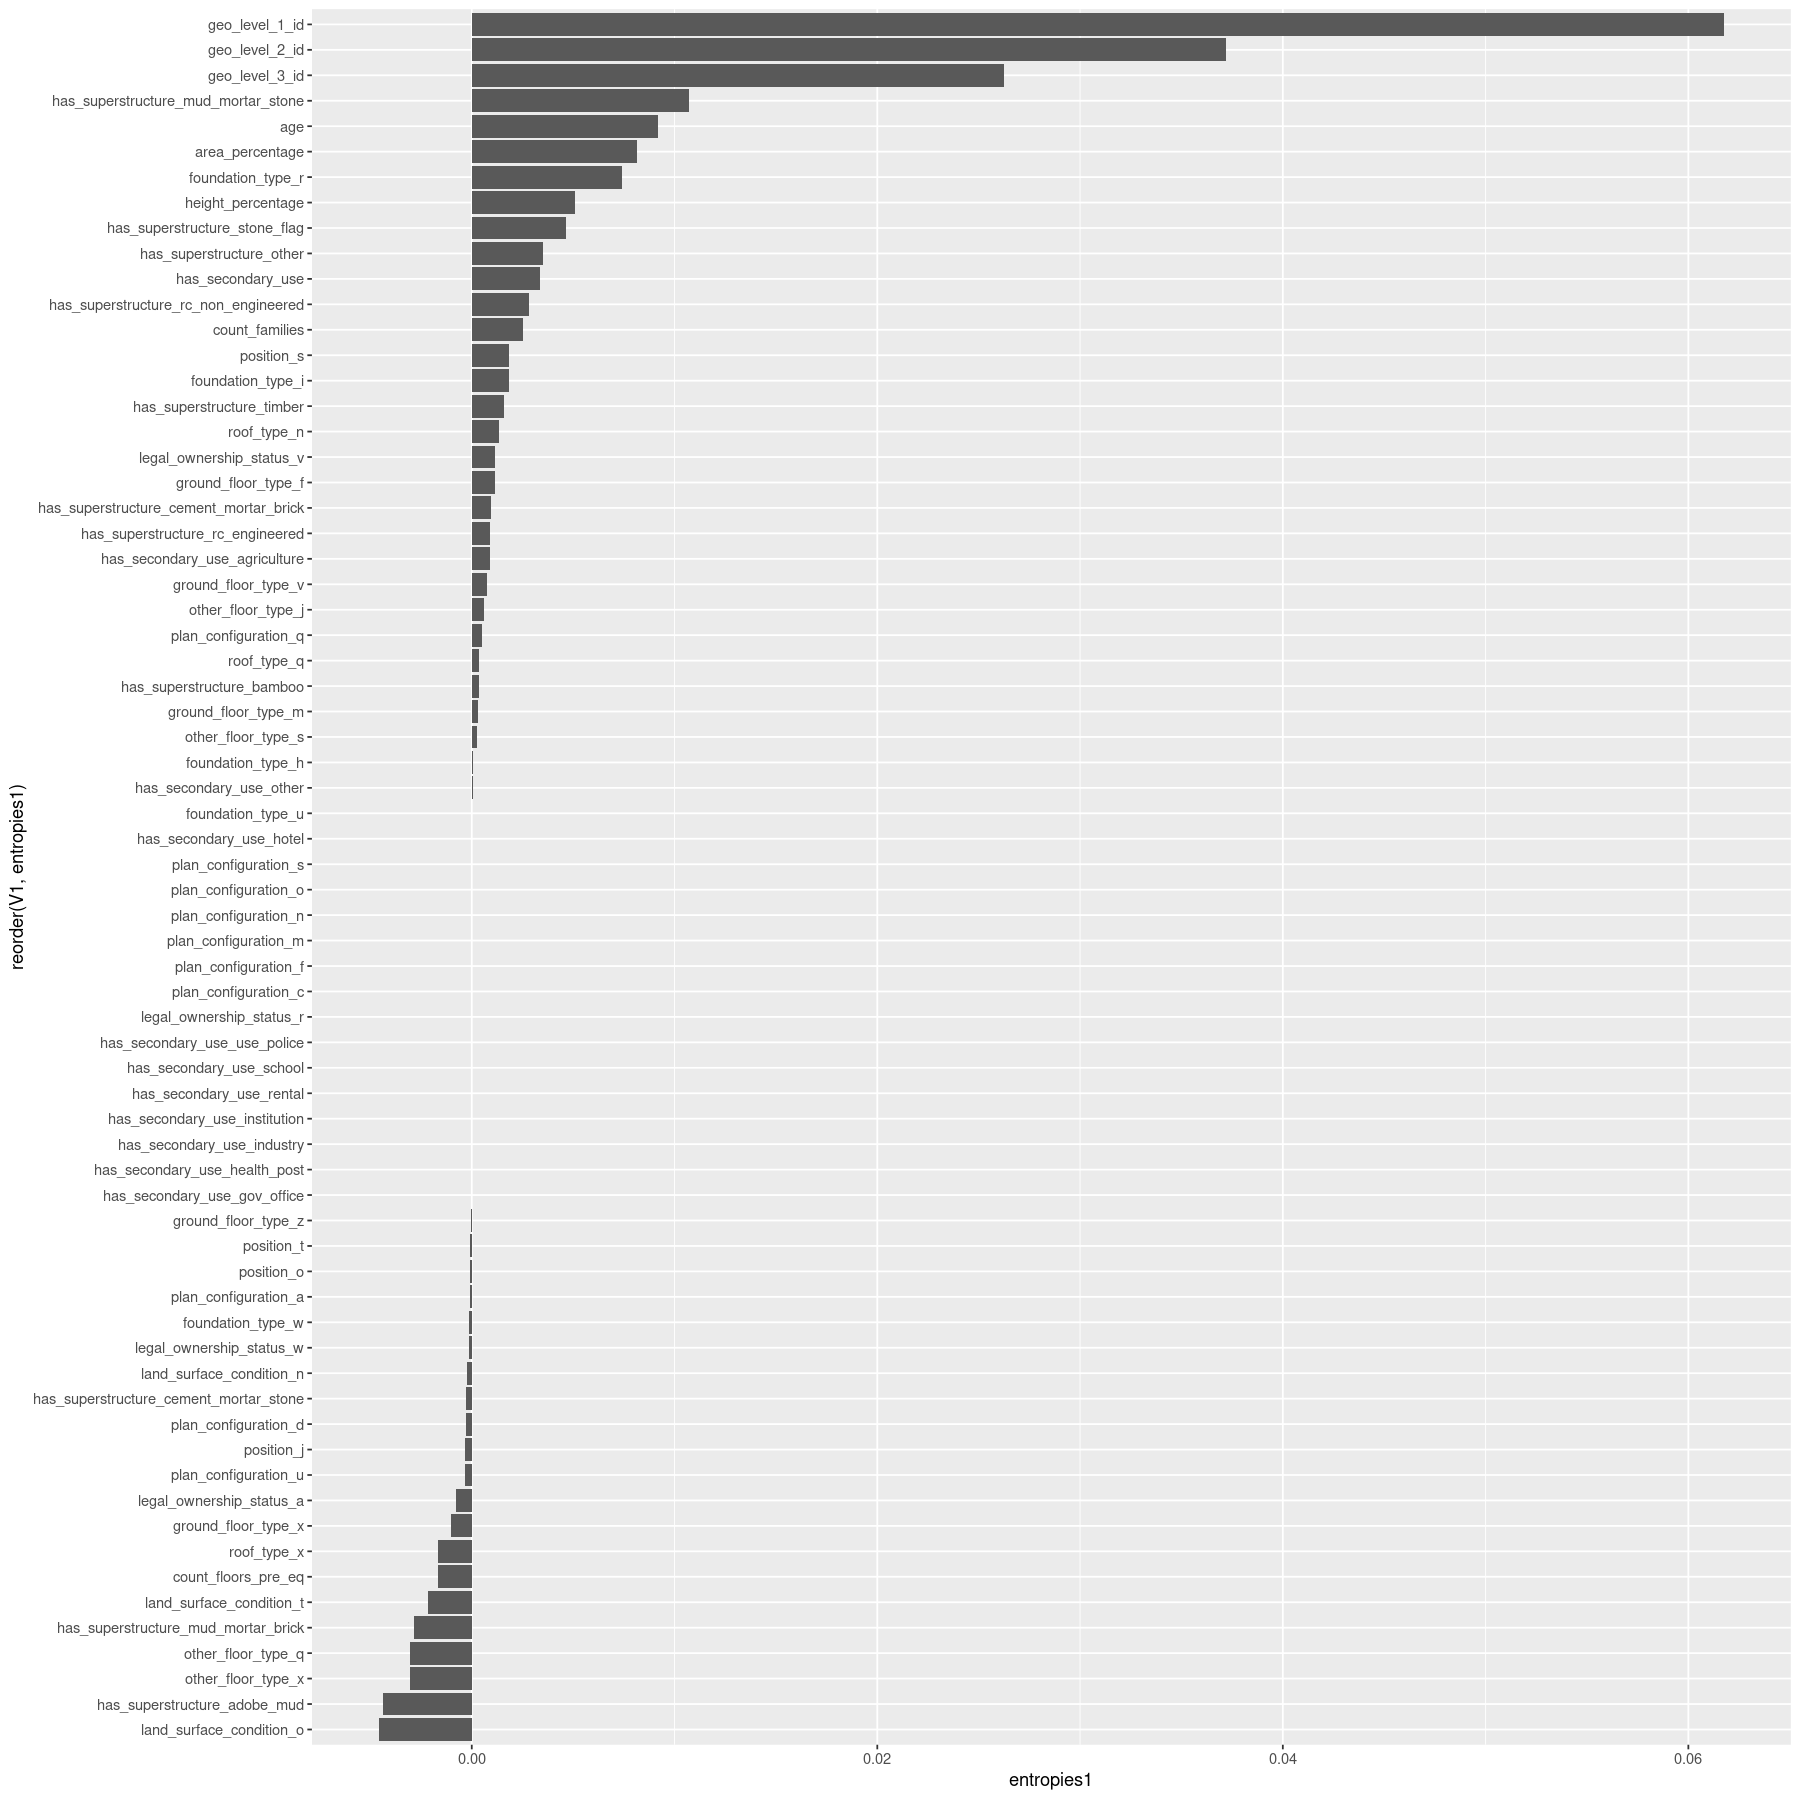

In [45]:
ggplot(relevancies, aes(x= relev, y=reorder(V1, relev))) + geom_bar(stat='identity')